In [1]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()
plt.style.use('seaborn-colorblind')

In [4]:
conn = sqlite3.connect('sql/sql.db')
cursor = conn.cursor()

In [5]:
#Executar só uma vez a cada vez que abrir o colab
f = io.open('sql/trabalho.sql', 'r', encoding='ISO-8859-1')
sql = f.read()
cursor.executescript(sql)

OperationalError: table ANSWERS already exists

In [6]:
def plot_paises(i,df):
    data = df.groupby("COUNTRYCODE").mean()
    x = data['PESO'] / data['TAMANHO']    
    y = data[i]
    n = [rt2[i] for i in data.index]
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    
    model = LinearRegression()
    x.fillna(0,inplace=True)
    y.fillna(0,inplace=True)
    model.fit([[i] for i in x],y)
    
    linha = [[x.min()],[x.max()]]
    y_pred = model.predict(linha)
    plt.plot(linha,y_pred)
    
    for j, txt in enumerate(n):
        ax.annotate(txt, (x[j], y[j]))

# Questão 5: Quais são os fatores sociais e culturais que parecem mais afetar a percepção?


In [7]:
df2 = pd.read_csv('dataset/6-dimensions-for-website-2015-12-08-0-100.csv', sep=';')
df2

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64,27,41,52,32,40
1,AFW,Africa West,77,20,46,54,9,78
2,ALB,Albania,#NULL!,#NULL!,#NULL!,#NULL!,61,15
3,ALG,Algeria,#NULL!,#NULL!,#NULL!,#NULL!,26,32
4,AND,Andorra,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,65
...,...,...,...,...,...,...,...,...
106,URU,Uruguay,61,36,38,98,26,53
107,VEN,Venezuela,81,12,73,76,16,100
108,VIE,Vietnam,70,20,40,30,57,35
109,ZAM,Zambia,#NULL!,#NULL!,#NULL!,#NULL!,30,42


In [8]:
conv = open("conv2.txt","r")
table1 = {}
p = conv.read().split("\n")
for x in p:
    if not len(x):
        break
    s = x.split("|")[0][:-1].upper()
    i = x.split("|")[1][1:].upper()
    table1[s] = int(i)

In [9]:
query = """
Select COUNTRYCODE, SUBSET,PERCENTAGE,VALOR,VALUE
From PESOS NATURAL JOIN ANSWERS NATURAL JOIN SIZE NATURAL JOIN IDH
WHERE SUBSET == TIPO

"""

df = pd.read_sql_query(query,conn)
df["TAMANHO"] = df["PERCENTAGE"] * df["VALOR"] * 0.01
df["PESO"] = df["TAMANHO"] * df["VALUE"]

table2 = {}
rt2 = {}
cultural = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']
for i in df2.index:
    sample = df2.loc[i]
    if sample["ctr"] in table1.keys():
        table2[table1[sample["ctr"]]] = {}
        for j in cultural:
            try:
                table2[table1[sample["ctr"]]][j] = int(sample[j])
            except:
                table2[table1[sample["ctr"]]][j] = np.NaN
        rt2[table1[sample["ctr"]]] = sample['country']
    
for j in cultural:
    cult = []
    for i in df.index:
        sample = df.loc[i]
        cult.append(table2[sample['COUNTRYCODE']][j])
    df[j] = cult
df

,COUNTRYCODE,SUBSET,PERCENTAGE,VALOR,VALUE,TAMANHO,PESO,pdi,idv,mas,uai,ltowvs,ivr
0,0,LESBIAN,33,437,0.0,144.21,0.000,11.0,55.0,79.0,70.0,60.0,63
1,0,LESBIAN,53,437,1.0,231.61,231.610,11.0,55.0,79.0,70.0,60.0,63
2,0,LESBIAN,2,437,0.5,8.74,4.370,11.0,55.0,79.0,70.0,60.0,63
3,0,GAY,51,1558,0.0,794.58,0.000,11.0,55.0,79.0,70.0,60.0,63
4,0,GAY,25,1558,1.0,389.50,389.500,11.0,55.0,79.0,70.0,60.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,11,BIM,65,294,0.0,191.10,0.000,35.0,89.0,66.0,35.0,51.0,69
4704,11,BIM,3,294,0.5,8.82,4.410,35.0,89.0,66.0,35.0,51.0,69
4705,11,TRANS,31,813,1.0,252.03,252.030,35.0,89.0,66.0,35.0,51.0,69
4706,11,TRANS,65,813,0.0,528.45,0.000,35.0,89.0,66.0,35.0,51.0,69


In [10]:
def boostreap(p,n_size = 500):
    values = np.zeros(n_size)
    
    d = pd.DataFrame(p)
    
    for i in range(n_size):
        sample = d[0].sample(replace = True,n = len(p))
        values[i] = sample.mean()
        
    return values

In [11]:
def gerarB(selecionados,df,n_size=50):
    p = []
    for country in selecionados:
        pais = df[df["COUNTRYCODE"] == country]

        for x in range(pais.shape[0]):
            sample = pais.iloc[x]
            for _ in range(int(sample["TAMANHO"])):
                p.append(sample["VALUE"])

    b = boostreap(p,n_size=n_size)
    
    return b

In [12]:
idx_to_name = {
    'pdi': 'Power distance index',
    'idv': 'Individualism vs. collectivism',
    'uai': 'Uncertainty avoidance',
    'mas': 'Masculinity vs. femininity',
    'ltowvs': 'Long-term orientation vs. short-term orientation',
    'ivr': 'Indulgence vs. restraint'
}

14 primeiros paises:
Malta, Spain, Czech Rep, Greece, Portugal, Belgium, France, Poland, Bulgaria, Slovenia, Croatia, Romania, Slovak Rep, Cyprus, 
14 ultimos paises:
Austria, Denmark, Ireland, Sweden, Finland, Germany, Great Britain, Netherlands, Estonia, Luxembourg, Lithuania, Latvia, Hungary, Italy, 


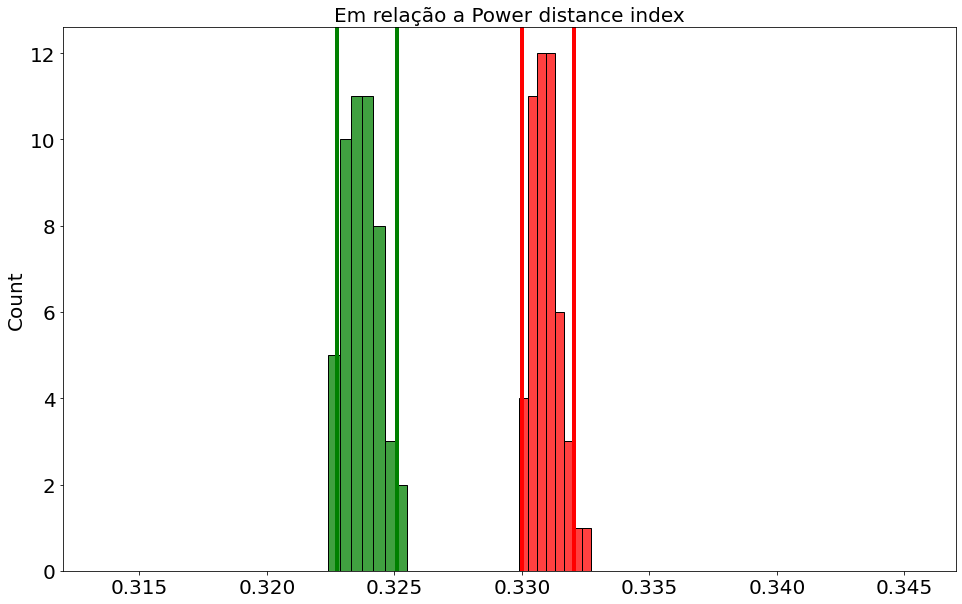

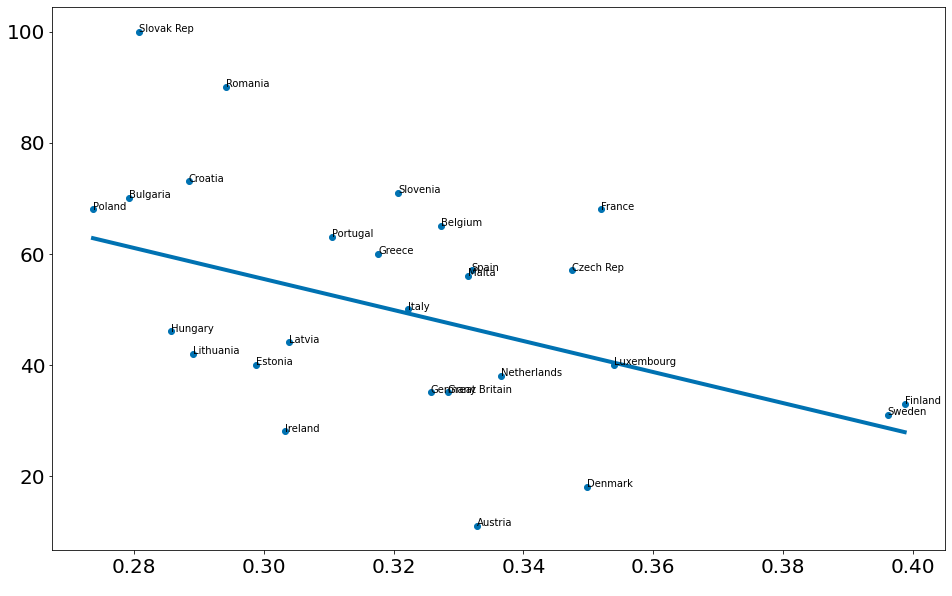

14 primeiros paises:
Lithuania, Finland, Germany, Ireland, Latvia, Sweden, France, Denmark, Belgium, Italy, Netherlands, Hungary, Great Britain, Cyprus, 
14 ultimos paises:
Portugal, Slovenia, Romania, Bulgaria, Croatia, Greece, Spain, Slovak Rep, Austria, Czech Rep, Malta, Luxembourg, Estonia, Poland, 


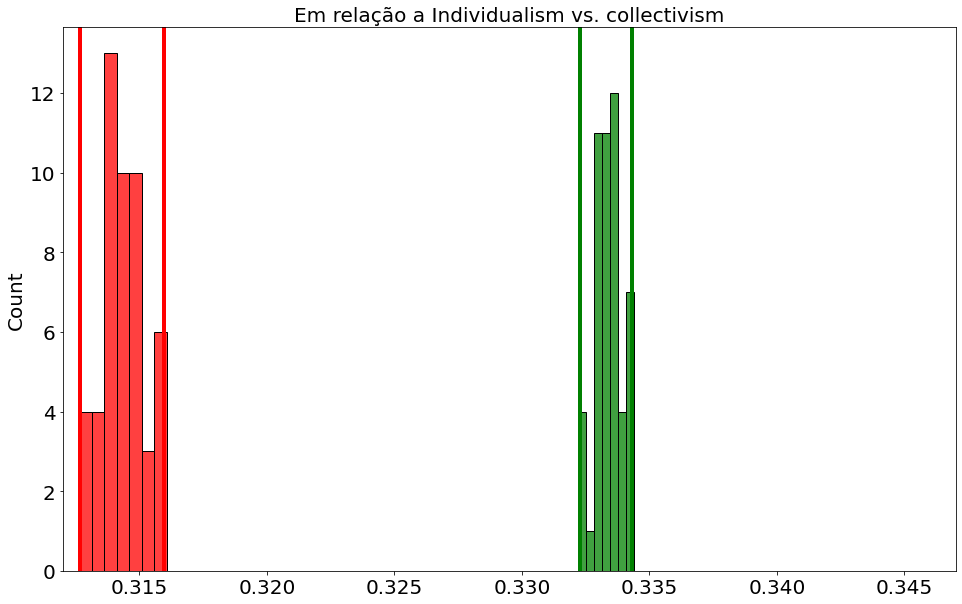

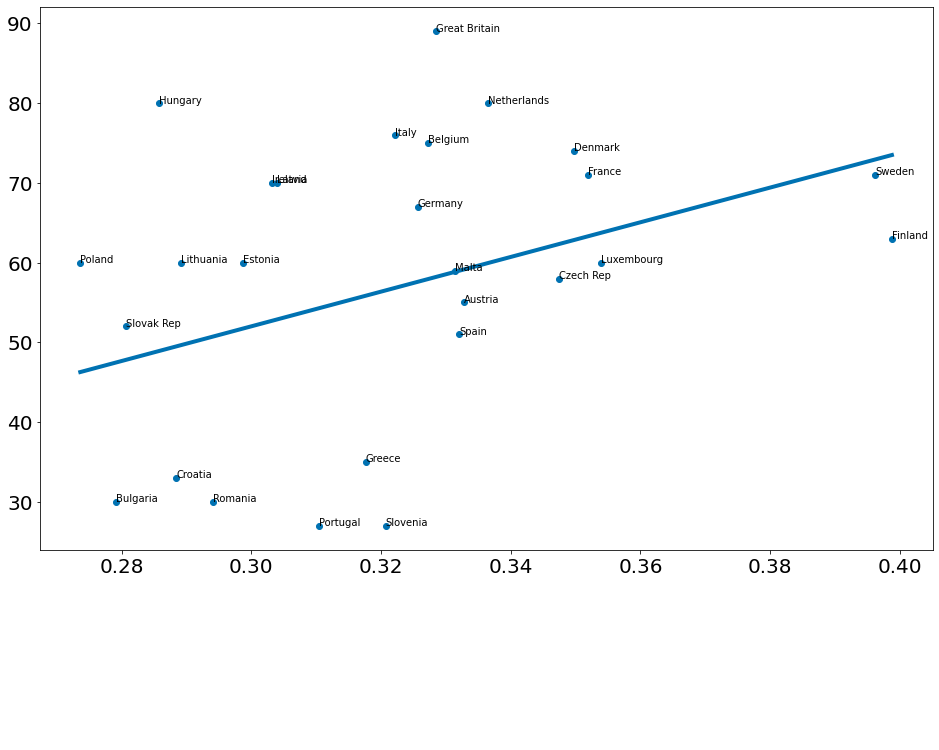

14 primeiros paises:
Italy, Croatia, Hungary, Bulgaria, France, Spain, Slovenia, Romania, Poland, Belgium, Malta, Portugal, Greece, Cyprus, 
14 ultimos paises:
Denmark, Sweden, Great Britain, Ireland, Slovak Rep, Netherlands, Finland, Estonia, Latvia, Germany, Lithuania, Luxembourg, Austria, Czech Rep, 


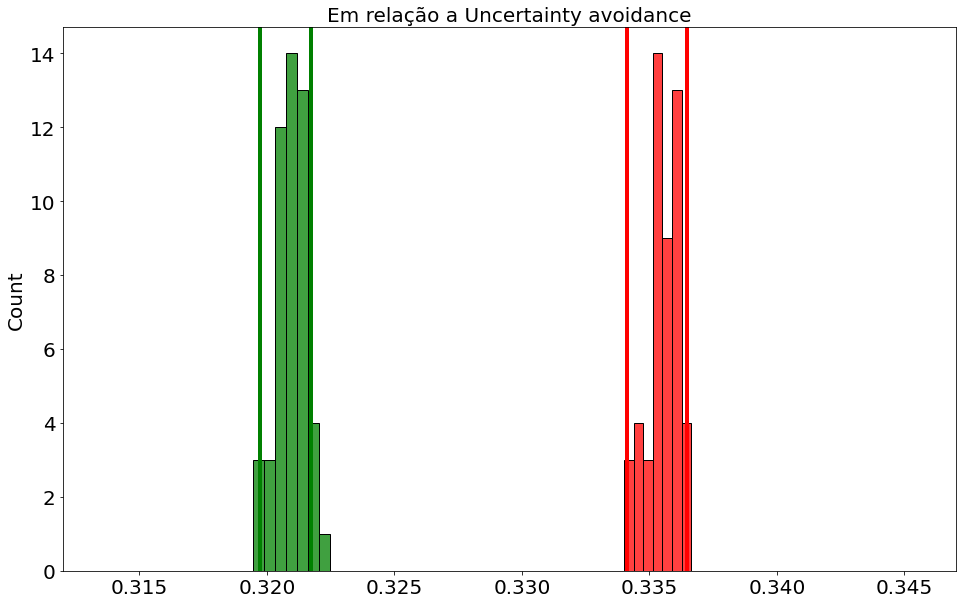

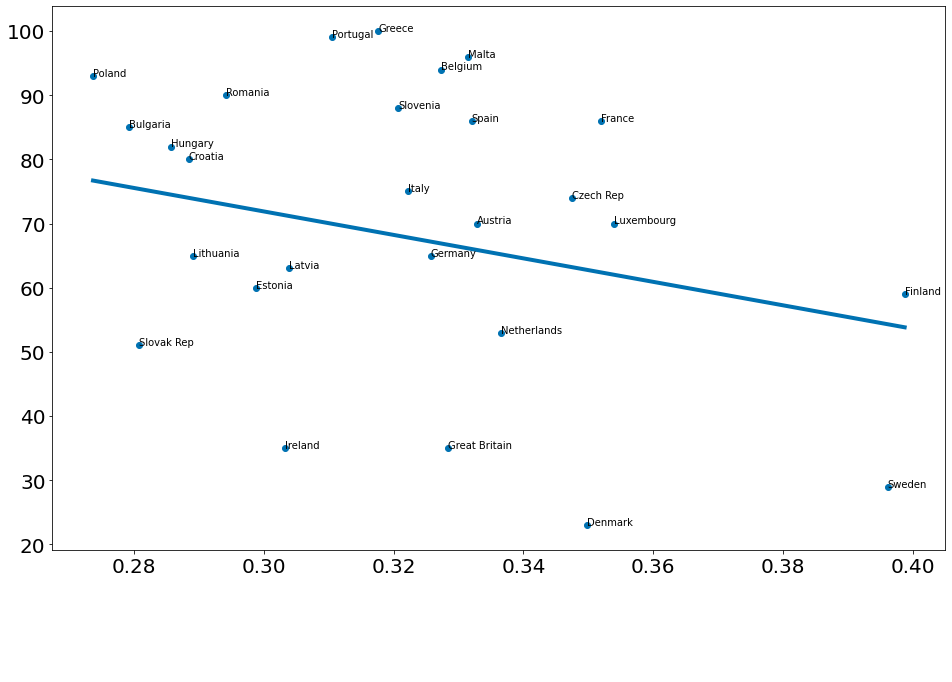

14 primeiros paises:
Malta, Luxembourg, Belgium, Greece, Czech Rep, Poland, Great Britain, Germany, Ireland, Italy, Austria, Hungary, Slovak Rep, Cyprus, 
14 ultimos paises:
Sweden, Latvia, Netherlands, Denmark, Lithuania, Slovenia, Finland, Estonia, Portugal, Croatia, Bulgaria, Romania, Spain, France, 


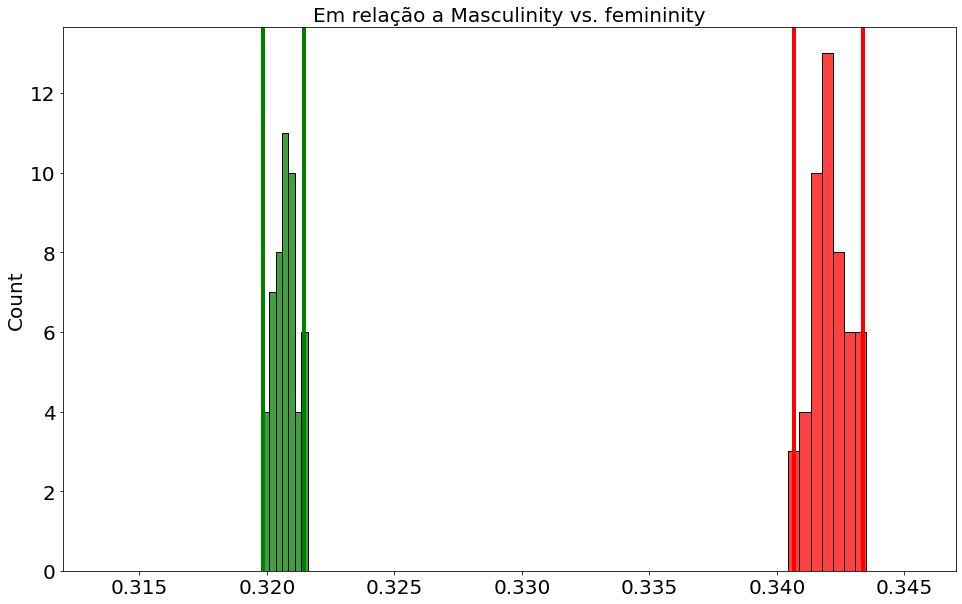

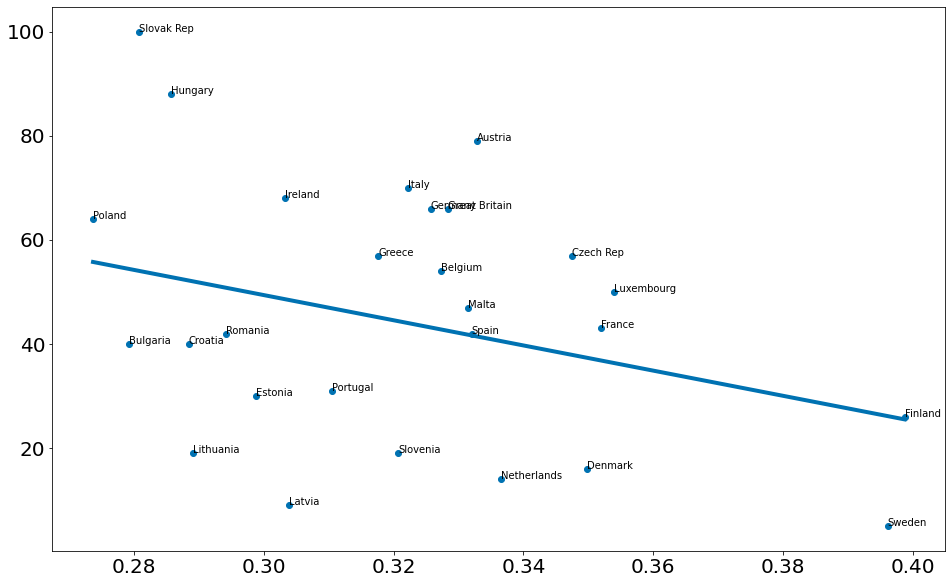

14 primeiros paises:
Austria, Italy, France, Luxembourg, Netherlands, Latvia, Bulgaria, Czech Rep, Slovak Rep, Lithuania, Estonia, Belgium, Germany, Cyprus, 
14 ultimos paises:
Ireland, Portugal, Denmark, Poland, Finland, Greece, Malta, Spain, Slovenia, Great Britain, Romania, Sweden, Hungary, Croatia, 


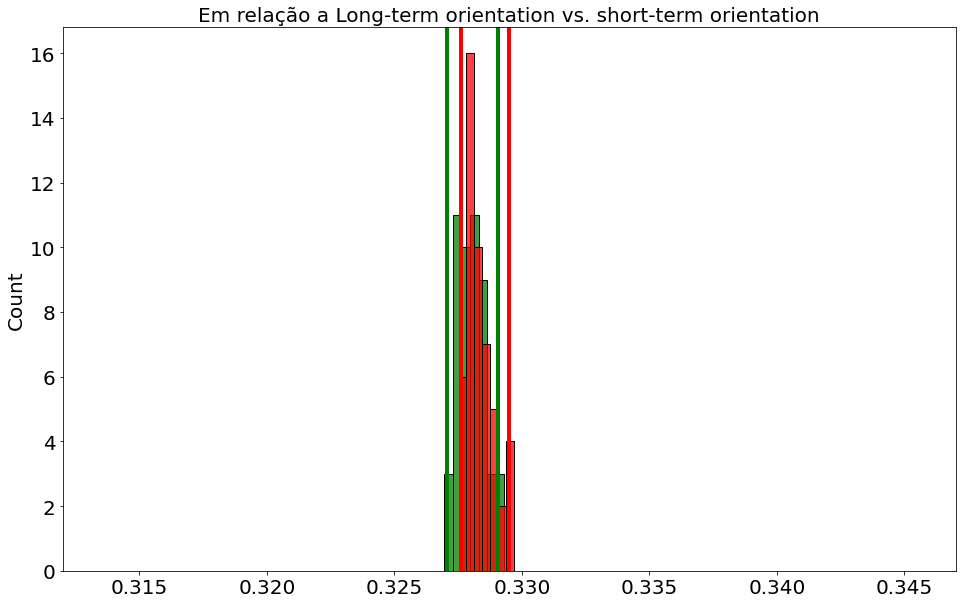

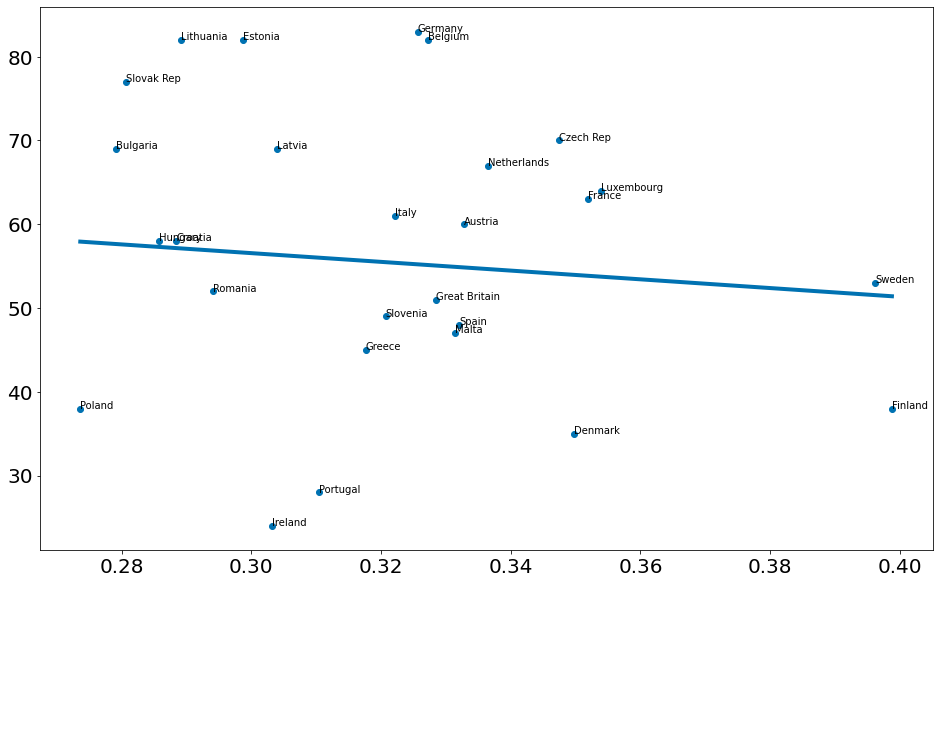

14 primeiros paises:
Slovenia, France, Greece, Luxembourg, Finland, Belgium, Austria, Ireland, Malta, Netherlands, Great Britain, Denmark, Cyprus, Sweden, 
14 ultimos paises:
Latvia, Bulgaria, Estonia, Lithuania, Romania, Slovak Rep, Czech Rep, Poland, Italy, Hungary, Portugal, Croatia, Germany, Spain, 


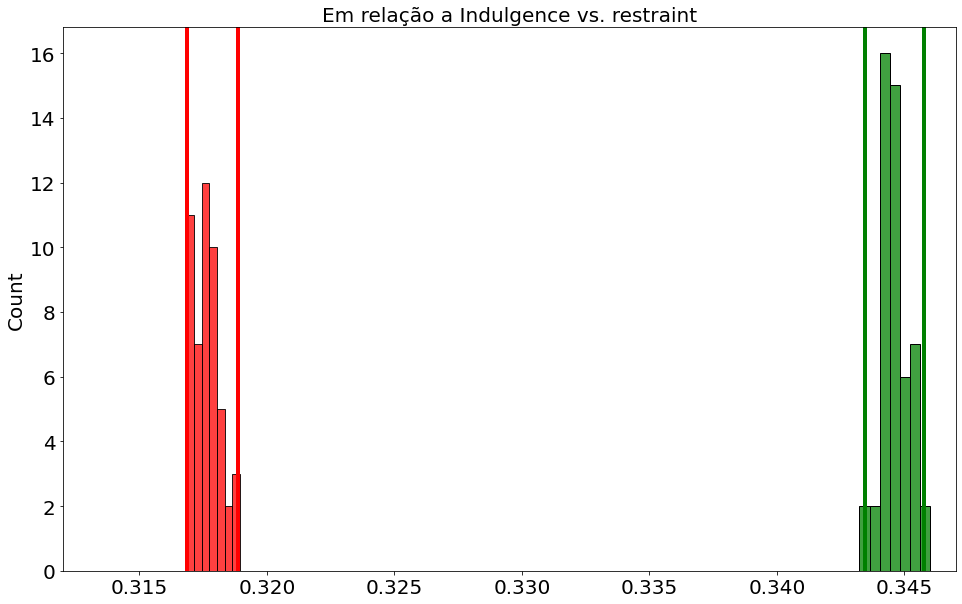

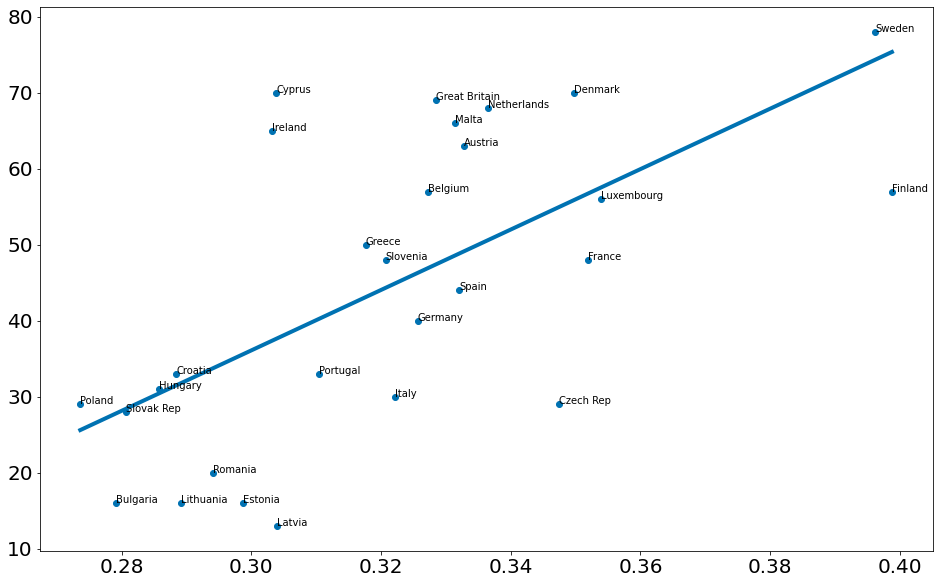

In [13]:
cultural = ['pdi', 'idv', 'uai', 'mas', 'ltowvs', 'ivr']
for x in cultural:
    indx = list(df.groupby("COUNTRYCODE").mean().sort_values(x).index)
    meio = int(len(indx)/2)

    maus = indx[:meio]
    bons = indx[meio:]
    
    bonsB = gerarB(bons,df)
    mausB = gerarB(maus,df)
    
    sns.histplot(bonsB,color="g")
    inf = np.percentile(bonsB,2.5)
    sup = np.percentile(bonsB,97.5)
    plt.axvline(inf,color="g")
    plt.axvline(sup,color="g")

    sns.histplot(mausB,color="r")
    inf = np.percentile(mausB,2.5)
    sup = np.percentile(mausB,97.5)
    plt.axvline(inf,color="r")
    plt.axvline(sup,color="r")
    plt.xlim(0.312, 0.347)
    plt.title("Em relação a {}".format(idx_to_name[x]))

    print(f"{meio} primeiros paises:")
    for i in bons:
        print(rt2[i], end = ', ')
    print()
    print(f"{meio} ultimos paises:")
    for i in maus:
        print(rt2[i], end = ', ')
    print()
    plt.show()
    plot_paises(x,df)
    plt.show()

## Correlação

In [14]:
from scipy.stats import pearsonr

v = []
for i in cultural:
    data = df.groupby("COUNTRYCODE").mean()
    x = data['PESO'] / data['TAMANHO']    
    y = data[i]
    xi = []
    yi = []
    for j in range(len(x)):
        if x[j] <1e4 and y[j] < 1e5:
            xi.append(x[j])
            yi.append(y[j])
    corr, _ = pearsonr(xi, yi)
    v.append((corr, i))

vs = sorted(v, key=lambda i: abs(i[0]), reverse = True)

print("Ordem dos fatores com maior correlação:")
for corr, i in vs:
    print(idx_to_name[i], corr)

Ordem dos fatores com maior correlação:
Indulgence vs. restraint 0.631649730058157
Power distance index -0.4858323680954163
Masculinity vs. femininity -0.35793961143559666
Uncertainty avoidance -0.33532915379459555
Individualism vs. collectivism 0.32988224278211054
Long-term orientation vs. short-term orientation -0.17178463912304454


## Regressão

In [15]:
from sklearn import linear_model

X = []
Y = []
for i in cultural:
    data = df.groupby("COUNTRYCODE").mean()
    y = data['PESO'] / data['TAMANHO']    
    x = data[i]

    xi = []
    yi = []
    for j in range(len(x)):
        if j == 3:
            continue
        xi.append(x[j])
        yi.append(y[j])

    X.append(xi)
    Y = yi
    
regr = linear_model.LinearRegression()
regr.fit(np.matrix(X).T, np.array(Y))
print("Score ", regr.score(np.matrix(X).T, Y))

coef = regr.coef_
print("Coeficientes")
for i in range(len(cultural)):
    print (idx_to_name[cultural[i]], coef[i])

Score  0.5943880390982774
Coeficientes
Power distance index -0.000179634701104883
Individualism vs. collectivism 0.0001268047344366902
Uncertainty avoidance 0.00012369668724834581
Masculinity vs. femininity -0.0004174152016809844
Long-term orientation vs. short-term orientation 0.0002353967571690422
Indulgence vs. restraint 0.0010745392859960552
